In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = "retina"

Let’s consider fitting a decision tree to some synthetic data. We will generate samples from two classes, both normal distributions but with different means.

In [2]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100,2))
train_labels = np.zeros(100)

#adding second class
train_data = np.r_[train_data,np.random.normal(size=(100,2),loc=2)] # loc referes to mean
train_labels = np.r_[train_labels,np.ones(100)]

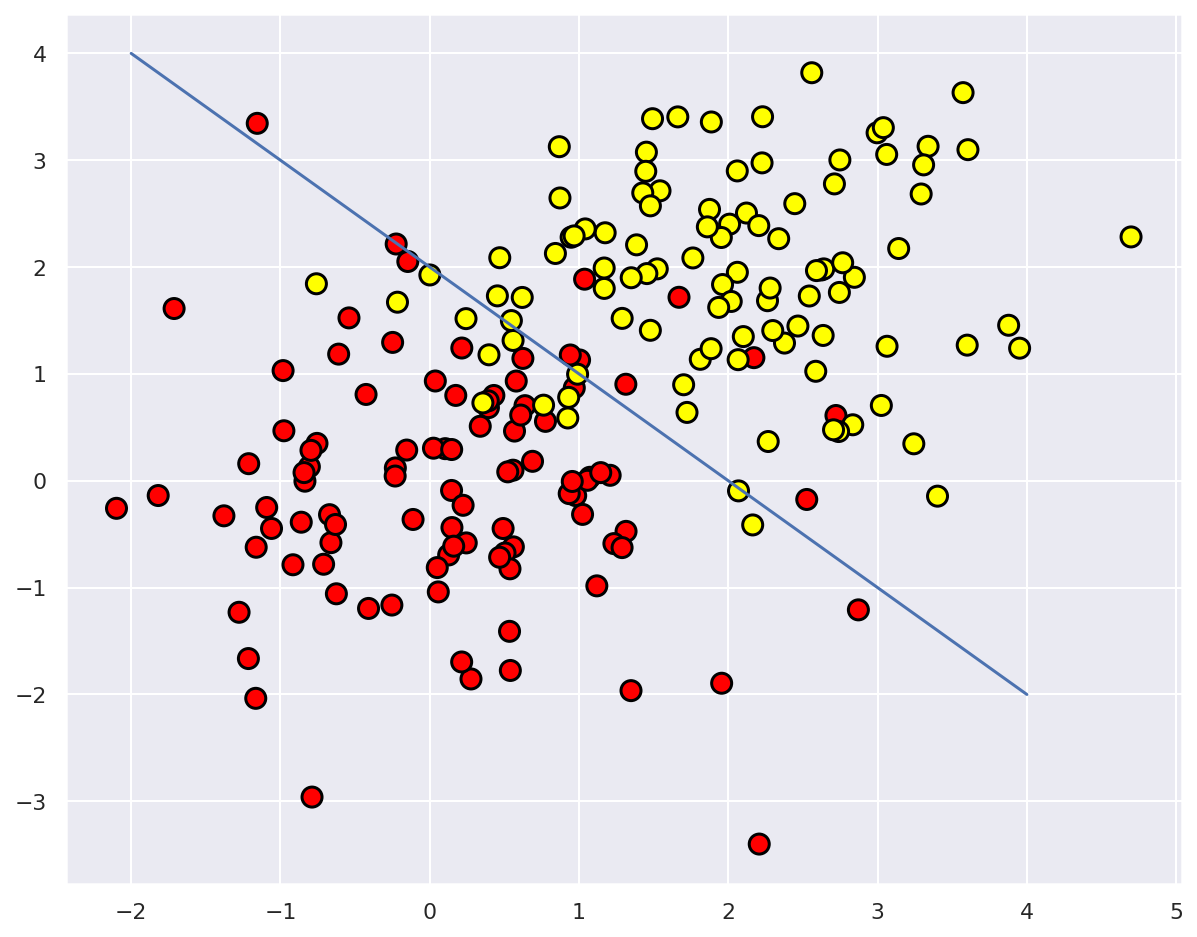

In [3]:
# lets plot our dataset
plt.figure(figsize=(10,8))
plt.scatter(
    train_data[:,0], # first feature
    train_data[:,1], # second feature
    c = train_labels, # hue
    s = 100,
    cmap="autumn",
    edgecolors="black",
    linewidths=1.5
)

plt.plot(range(-2,5),range(4,-3,-1)) # approximate decision boundary

Let’s try to separate these two classes by training an Sklearn decision tree. We will use max_depth parameter that limits the depth of the tree. Let’s visualize the resulting separating boundary.

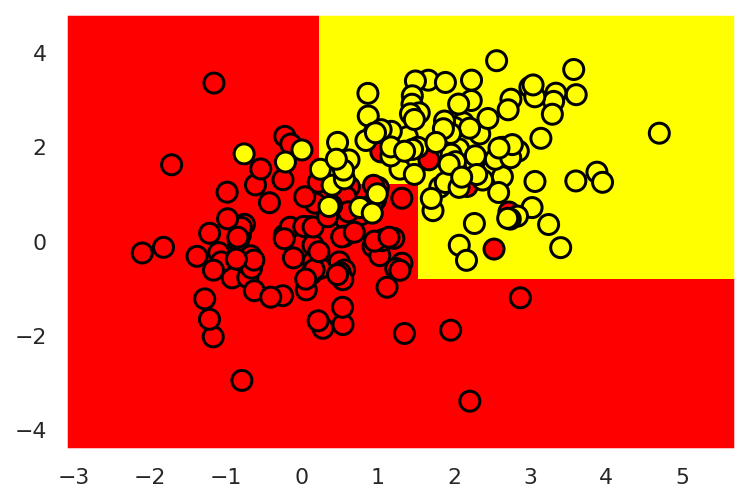

In [4]:
from sklearn.tree import DecisionTreeClassifier


# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1 # first feature
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1 # second feature
    # generates all points of the given two features in 2D space
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data) # xx: x co-ordinates, yy: y co-ordinates
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
);

In [5]:
import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [6]:
tree_graph_to_png(
    tree=clf_tree,
    feature_names=["x1", "x2"],
    png_file_to_save="decision_tree1.png",
)

### Decision trees and nearest neighbors method in a customer churn prediction task

In [7]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [8]:
df = pd.read_csv(DATA_PATH+"telecom_churn.csv")

# df["International plan"].value_counts()
# df["Voice mail plan"].value_counts()

# International plan and Voice mail plan are encoded as object
# lets turn them numeric representaion


df["International plan"] = pd.factorize(df["International plan"])[0] # we just need the codes
df["Voice mail plan"] = pd.factorize(df["Voice mail plan"])[0]

df["Churn"] = df["Churn"].astype("int")
states = df["State"]

y = df["Churn"]
df.drop(["State","Churn"],axis=1,inplace=True)

In [9]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [10]:
df.shape

(3333, 18)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          3333 non-null   int64  
 1   Area code               3333 non-null   int64  
 2   International plan      3333 non-null   int64  
 3   Voice mail plan         3333 non-null   int64  
 4   Number vmail messages   3333 non-null   int64  
 5   Total day minutes       3333 non-null   float64
 6   Total day calls         3333 non-null   int64  
 7   Total day charge        3333 non-null   float64
 8   Total eve minutes       3333 non-null   float64
 9   Total eve calls         3333 non-null   int64  
 10  Total eve charge        3333 non-null   float64
 11  Total night minutes     3333 non-null   float64
 12  Total night calls       3333 non-null   int64  
 13  Total night charge      3333 non-null   float64
 14  Total intl minutes      3333 non-null   

Let’s allocate 70% of the set for training (X_train, y_train) and 30% for the hold-out set (X_holdout, y_holdout). The hold-out set will not be involved in tuning the parameters of the models. We’ll use it at the end, after tuning, to assess the quality of the resulting model.

In [12]:
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train,X_holdout, y_train, y_holdout = train_test_split(
    df.values, y, test_size = 0.3, random_state=17
)
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
tree.fit(X_train,y_train)

knn = KNeighborsClassifier(n_neighbors=10)

# KNN wont work without feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.fit_transform(X_holdout)
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=10)

In [13]:
# Quality assessment
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout,tree_pred)

0.94

In [14]:
knn_pred = knn.predict(X_holdout_scaled)
accuracy_score(y_holdout,knn_pred)

0.886

Now, let’s identify the parameters for the tree using cross-validation.

In [15]:
# Hyperparameter tuning with CV
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {
    "max_depth": range(1,11),
    "max_features":range(4,19)
}

tree_grid = GridSearchCV(tree,tree_params,cv=5,n_jobs=-1,verbose=True)
tree_grid.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [16]:
# Let’s list the best parameters and the corresponding mean accuracy from cross-validation.
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [17]:
tree_grid.best_score_ # remember this is accuracy on the training set

0.94257014456259

In [18]:
# accuracy on the holdout set
accuracy_score(y_holdout,tree_grid.predict(X_holdout))

0.946

In [19]:
## Lets draw the tree
tree_graph_to_png(
    tree = tree_grid.best_estimator_,
    feature_names=df.columns,
    png_file_to_save="decision_tree4.png"
)

Now, let’s tune the number of neighbors k for k-NN:

In [20]:
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

knn_params = {"knn__n_neighbors": range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'knn__n_neighbors': 7}, 0.8859867109023905)

In [21]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout)) 

0.89

### Random Forest Implementation

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=17)
# lets check cross val score without any hyperparameter tuning
print(np.mean(cross_val_score(forest,X_train,y_train,cv=5)))

0.9494233119813256


In [23]:
# lets do hyperparameter tuning with cv
forest_params = {
    "max_depth":range(6,12),
    "max_features":range(4,19)
}

forest_grid = GridSearchCV(forest,forest_params,cv=5,n_jobs=-1,verbose=True)

forest_grid.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(6, 12),
                         'max_features': range(4, 19)},
             verbose=True)

In [24]:
forest_grid.best_params_

{'max_depth': 9, 'max_features': 6}

In [25]:
forest_grid.best_score_

0.9511372931045574

In [26]:
# accuracy on holdout set
accuracy_score(y_holdout,forest_grid.predict(X_holdout))

0.953

### Complex Case for Decision Trees

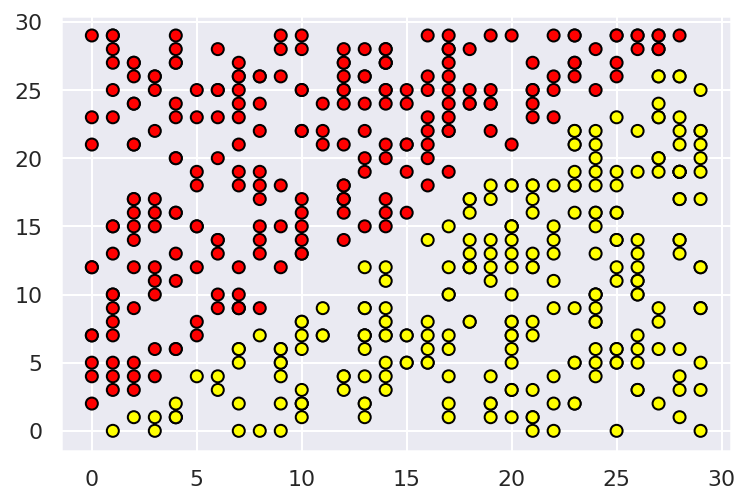

In [27]:
def form_linearly_seperable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data,target = [],[]
    for i in range(n):
        x1 = np.random.randint(x1_min,x1_max)
        x2 = np.random.randint(x2_min,x2_max)
        if np.abs(x1-x2)>0.5:
            data.append([x1,x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)


X,y = form_linearly_seperable_data()
plt.scatter(X[:,0],X[:,1],c=y,cmap="autumn",edgecolors="black")

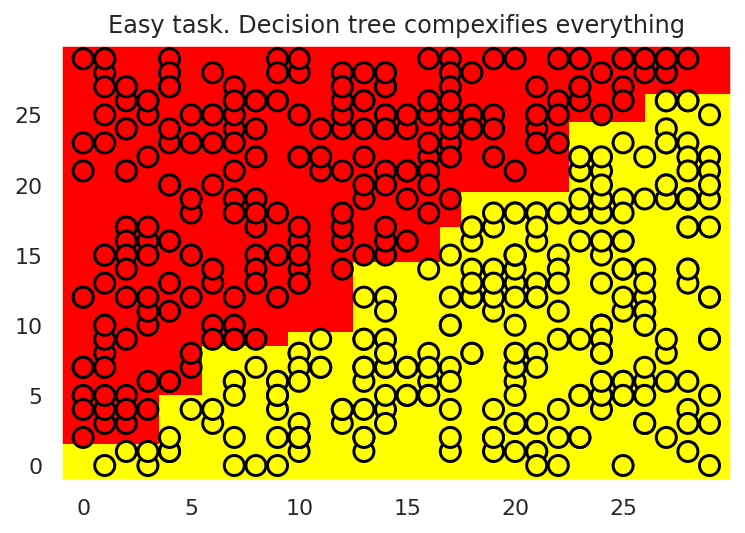

In [28]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")

plt.scatter(
    X[:, 0], X[:, 1], c=y, s=100, cmap="autumn", edgecolors="black", linewidth=1.5
)
plt.title("Easy task. Decision tree compexifies everything");

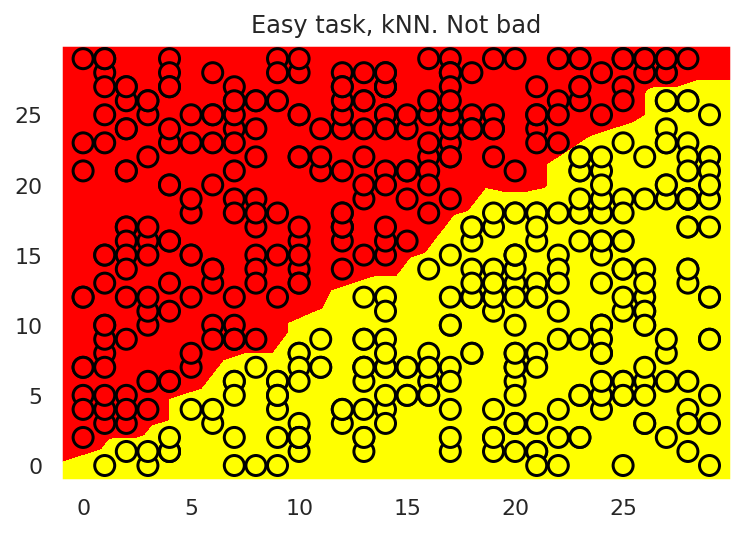

In [29]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    X[:, 0], X[:, 1], c=y, s=100, cmap="autumn", edgecolors="black", linewidth=1.5
)
plt.title("Easy task, kNN. Not bad");


### Decision Trees and k-NN in a Task of MNIST Handwritten Digits Recognition

In [30]:
from sklearn.datasets import load_digits

data = load_digits()
X,y = data.data,data.target

In [31]:
X.shape,y.shape

((1797, 64), (1797,))

In [32]:
# a snigle digit
X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

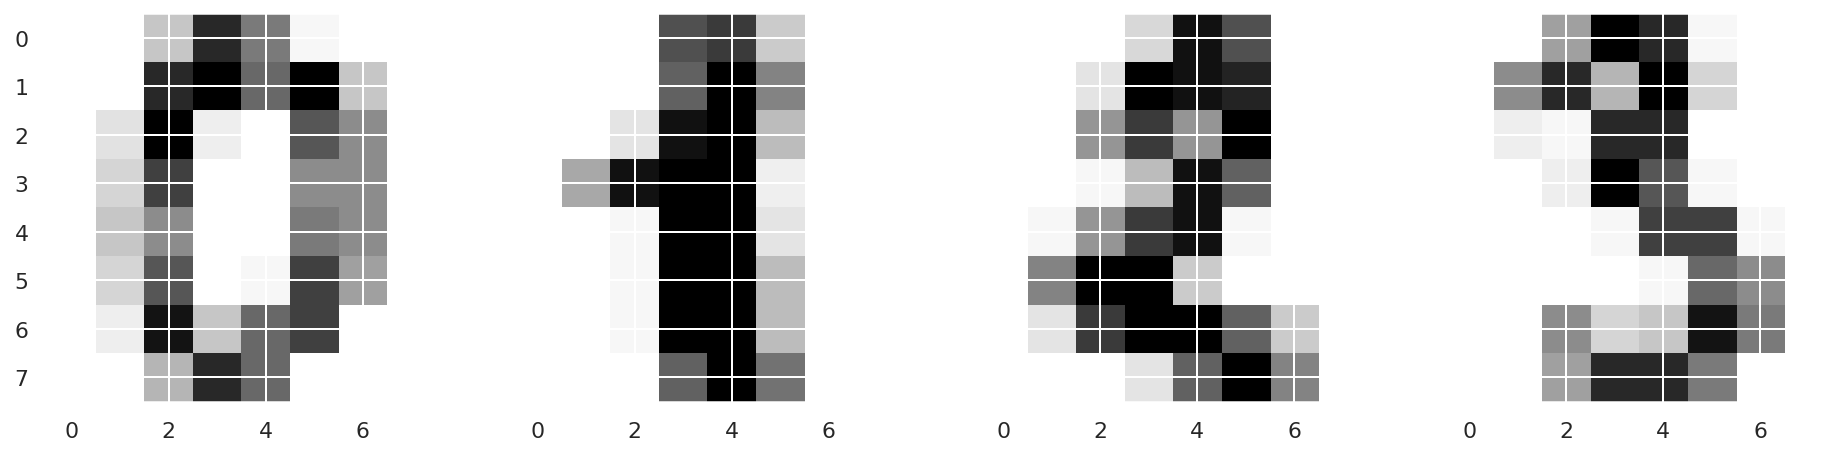

In [33]:
# lets plot some
f,axes = plt.subplots(1,4,sharey=True,figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]),cmap="Greys")

Let’s select 70% of the dataset for training (X_train, y_train) and 30% for holdout (X_holdout, y_holdout). The holdout set will not participate in model parameters tuning; we will use it at the end to check the quality of the resulting model.

In [34]:
X_train,X_holdout,y_train,y_holdout = train_test_split(
    X,y,test_size=0.3,random_state=17
)

In [35]:
# Let’s train a decision tree and k-NN with our random parameters.

tree = DecisionTreeClassifier(max_depth=5,random_state=17)

knn_pipe = Pipeline([
    ("scaler",StandardScaler()),
    ("knn",KNeighborsClassifier(n_neighbors=10))
])

# lets fit these two models
tree.fit(X_train,y_train)
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=10))])

In [36]:
# prediction on the holdout set
tree_pred = tree.predict(X_holdout)
knn_pred = knn_pipe.predict(X_holdout)

#knn
accuracy_score(y_holdout,knn_pred)


0.975925925925926

In [37]:
#DT
accuracy_score(y_holdout,tree_pred)

0.6666666666666666

Now let’s tune our model parameters using cross-validation as before, but now we’ll take into account that we have more features than in the previous task: 64.

In [38]:
tree_params = {
    "max_depth": [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
    "max_features":[1, 2, 3, 5, 10, 20, 30, 50, 64]
}

tree_grid = GridSearchCV(tree,tree_params,cv=5,n_jobs=-1,verbose=True)

tree_grid.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

In [39]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

In [40]:
np.mean(
    cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5)
)  # 0.987

0.9864858028204642

In [41]:
np.mean(
    cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5)
)  # 0.935

0.9753462341111744

### Complex Case for the Nearest Neighbors Method

Let’s consider another simple example. In the classification problem, one of the features will just be proportional to the vector of responses, but this won’t help for the nearest neighbors method.

In [45]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)

    # first feature is proportional to target
    x1 = 0.3 * y

    # other features are noise

    x_other = np.random.random(size=[n_obj, n_feat - 1])

    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y


X, y = form_noisy_data()
    

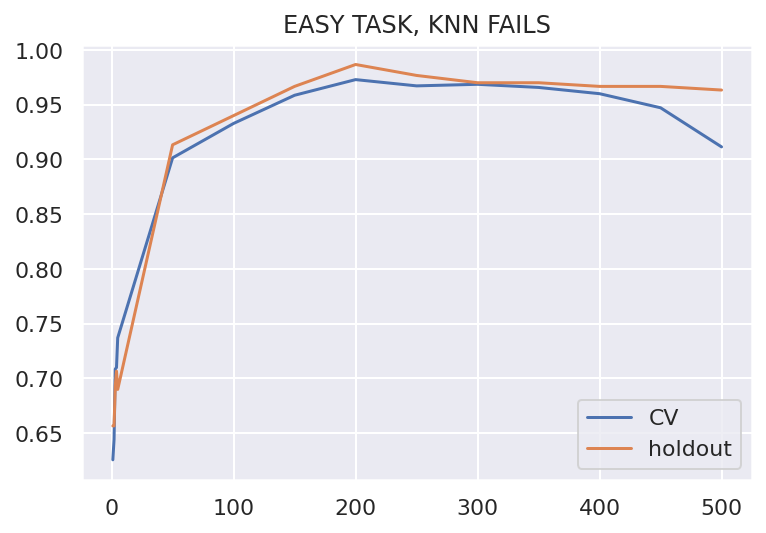

In [46]:
X_train,X_holdout,y_train,y_holdout = train_test_split(
    X,y,test_size=0.3,random_state=17
)

# plotting validation curve for n_neighb

from sklearn.model_selection import cross_val_score

cv_scores,holdout_scores = [],[]

n_neighb = [1,2,3,4,5]+list(range(50,550,50)) # size 15

for k in n_neighb:

    knn_pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=k))
        ]
    )

    # cv scores size = 15
    cv_scores.append(np.mean(cross_val_score(knn_pipe,X_train,y_train,cv=5)))

    # holdout scores size 15
    knn_pipe.fit(X_train,y_train)
    holdout_scores.append(accuracy_score(y_holdout,knn_pipe.predict(X_holdout)))



# plotting
plt.plot(n_neighb,cv_scores,label = "CV")
plt.plot(n_neighb,holdout_scores,label="holdout")
plt.title("EASY TASK, KNN FAILS")
plt.legend()

In [47]:
# for DT
tree = DecisionTreeClassifier(random_state=17,max_depth=1)
# for CV
tree_cv_scores = np.mean(cross_val_score(tree,X_train,y_train))
# for holdout
tree.fit(X_train,y_train)
tree_holdout_score = accuracy_score(y_holdout,tree.predict(X_holdout))

tree_cv_scores, tree_holdout_score

(1.0, 1.0)